<a href="https://colab.research.google.com/github/JaiVR/suttmltask_1/blob/main/suttml_task1_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [757]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [758]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [759]:
dataset= pd.read_csv('sutt.csv')

In [760]:
dataset = dataset.astype(str)


In [761]:
dataset = dataset.drop('BIRTHDAY', axis=1)

In [762]:
dataset.head()

,SEX,AGES,ADMISSION MODE,CGPA - 1,CGPA-2,CLUB / DEPARTMENT,BOARD STUDIED,DAYS SINCE LAST SHOWER,TREATS GIVEN,HAS A S/O ?,ATTENDS LECTURES,CHARACTER,PIZZERIA EXPENDITURE (annual),GRAMS / MONTH,GPL
0,male,19.0,BITSAT,8.85,7.0,nan,CBSE,12,4,YES,NO,LITE,20495,5.0,NO
1,female,21.0,DASA,7.01,9.0,nan,ICSE,1,1,YES,NO,GHOT,2361,0.2,YES
2,female,20.0,BITSAT,3.0,8.0,nan,CBSE,5,4,YES,NO,GHOT,8548,0.3,YES
3,female,nan,DASA,nan,nan,nan,CBSE,7,4,YES,NO,GHOT,4086,0.2,YES
4,male,21.0,BITSAT,5.65,9.0,nan,CBSE,7,3,YES,NO,LITE,13767,8.5,NO


In [763]:
X = dataset.iloc[:, :-1].values
# y is the gpl ,the dependent variable
y = dataset.iloc[:, -1].values

In [764]:
#encoding the categorical data using one hot encoding
#independent variable
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

dataset.iloc[:, 5].replace('', 'NA', inplace=True)

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,2,5,6,9,10,11])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [765]:
#fixing the casing issues in club/dept. column
def replace_value(value):
    if value == 's':
        return 'sutt'
    elif value == 'd' or value == 'v':
        return 'dvm'
    elif value == 'g':
        return 'gaming club'
    elif value == 'm':
        return 'mountaineering club'
    else:
        return value


dataset[' CLUB / DEPARTMENT'] = dataset[' CLUB / DEPARTMENT'].str.lower().str[0].apply(replace_value)

In [766]:
#taking care of missing values
#this code replaces the missing value with the mean of that particular column

columns_to_impute = [1,3,4,7,8,12,13]
X[:, columns_to_impute] = X[:, columns_to_impute].astype(float)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
imputer.fit(X[:, columns_to_impute])
X[:, columns_to_impute] = imputer.transform(X[:, columns_to_impute])

In [767]:
#encoding dependent variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [768]:
#splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [769]:
#feauture scaling using standaridization
from sklearn.preprocessing import StandardScaler
columns_to_stand = [1,3,4,7,9,13,14,15]
sc = StandardScaler()
X_train[:, columns_to_stand] = sc.fit_transform(X_train[:, columns_to_stand])
X_test[:, columns_to_stand] = sc.transform(X_test[:, columns_to_stand])
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [770]:
print(y_train)

[0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0
 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1
 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0
 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1
 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1
 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 

converting X and y to tensors

In [771]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [772]:
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [773]:
class Model(nn.Module):
  def __init__(self,in_features=41,h1=16,h2=8,h3=4,out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    self.fc3 = nn.Linear(h2,h3)
    # self.fc4 = nn.Linear(h3,h4)
    self.out = nn.Linear(h3,out_features)
    self.sigmoid = torch.nn.Sigmoid()
    #torch.nn.init.xavier_uniform(self.fc1.weight)
    #torch.nn.init.xavier_uniform(self.fc2.weight)
    #torch.nn.init.xavier_uniform(self.fc3.weight)
    #torch.nn.init.xavier_uniform(self.fc4.weight)
    #torch.nn.init.xavier_uniform(self.out.weight)

  def forward(self,x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    # x = F.relu(self.fc4(x))
    x = self.out(x)
    x = self.sigmoid(x)
    return x

In [774]:
#pick a manual seed
model = Model()

In [775]:
#criterion of model to measure the error
criterion = nn.CrossEntropyLoss()
#choosing adam optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(),lr= 2e-4)

In [776]:
epochs = 100
losses = []
for i in range(epochs):
  y_pred = model.forward(torch.nan_to_num(X_train)).squeeze(1)
  # print(y_pred)
  #measure the loss/error
  loss = criterion(y_train,y_pred)
  losses.append(loss.detach().numpy())

  #print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch:{i} and loss:{loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch:0 and loss:1.9900884628295898
Epoch:10 and loss:1.1029491424560547
Epoch:20 and loss:0.688548743724823
Epoch:30 and loss:0.4773825705051422
Epoch:40 and loss:0.3576574921607971
Epoch:50 and loss:0.28265950083732605
Epoch:60 and loss:0.2316058725118637
Epoch:70 and loss:0.19454829394817352
Epoch:80 and loss:0.16635504364967346
Epoch:90 and loss:0.14416775107383728


Text(0.5, 0, 'epochs')

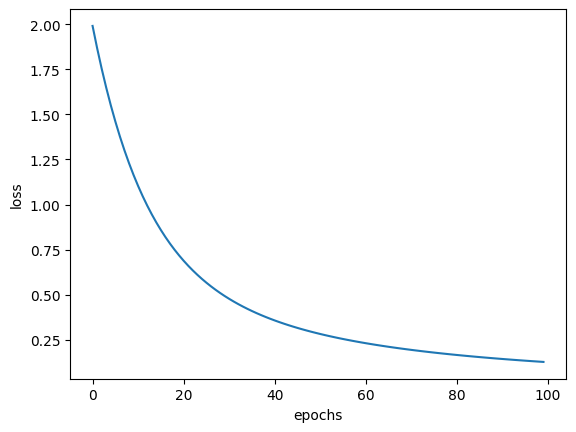

In [777]:
plt.plot(range(epochs),losses)
plt.ylabel("loss")
plt.xlabel("epochs")

In [778]:
with torch.no_grad():
  y_eval = model.forward(torch.nan_to_num(X_test)).squeeze(1)
  loss = criterion(y_eval,y_test)

In [779]:
loss

tensor(490.8144)

In [780]:
correct = 0
with torch.no_grad():
  for i,data in enumerate(torch.nan_to_num(X_test)):
    y_pred = model.forward(data)

    print(f'{i+1} .) {str(y_test)} \t {y_test[i]}')

    if y_pred.argmax().item() == y_test[i]:
      correct +=1
print(f' here we go ! correct={correct}')

1 .) tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0.]) 	 1.0
2 .)